In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Circle, Rectangle, Arc
from sklearn import mixture
from sklearn import ensemble
from sklearn import model_selection
from sklearn.metrics import accuracy_score as accuracy
from sklearn.metrics import log_loss
import time
import itertools
import operator

<font size=4 color='blue'>
    Load the data and create some useful fields 
    並進行資料前處理
<font size=3 color='gray'>
show the newly created fields as a sanity check

In [2]:
### load training data and drop nans
data=pd.read_csv('data.csv')

Dropping nans

We are gonna make a variable without nan for our exploratory analysis.

In [3]:
nona =  data[pd.notnull(data['shot_made_flag'])]

<font size=4 color='blue'>
    Feature engineering
    並進行資料前處理
<font size=3 color='gray'>
Now let's start feature engineering. There are many features which should be modified or deleted for brevity.

First, let's take a look at all the variables.

In [4]:
data.head()

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,...,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,...,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,...,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5


<font size=3.5>
loc_x, loc_y, lat and lon

Text(0.5,1,'lat and lon')

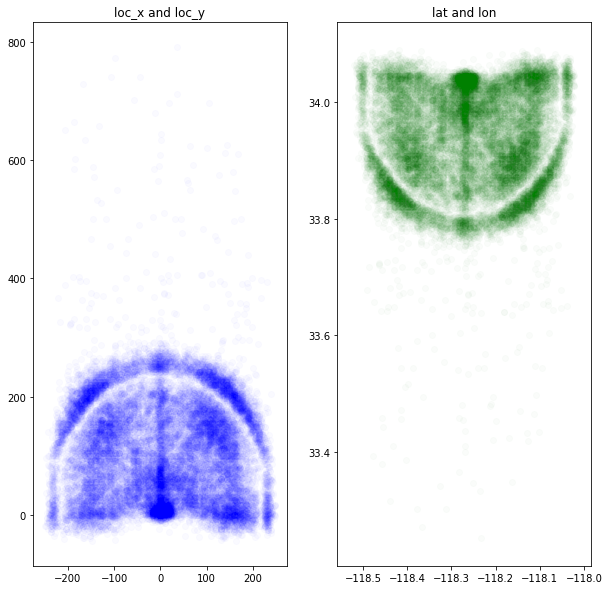

In [5]:
alpha = 0.02
plt.figure(figsize=(10,10))

# loc_x and loc_y
plt.subplot(121)
plt.scatter(nona.loc_x, nona.loc_y, color='blue', alpha=alpha)
plt.title('loc_x and loc_y')

# lat and lon
plt.subplot(122)
plt.scatter(nona.lon, nona.lat, color='green', alpha=alpha)
plt.title('lat and lon')

These plot are shaped like basket ball courts. So loc_x, loc_y, lat and lon seem to mean the position from which the ball was tossed. However, since the region under the net is half-circle-shaped, it would be more suitable to transform the variable into polar coodinate.

In [6]:
data['dist'] = np.sqrt(data['loc_x']**2 + data['loc_y']**2)

loc_x_zero = data['loc_x'] == 0
data['angle'] = np.array([0]*len(data))
data['angle'][~loc_x_zero] = np.arctan(data['loc_y'][~loc_x_zero] / data['loc_x'][~loc_x_zero])
data['angle'][loc_x_zero] = np.pi / 2 

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


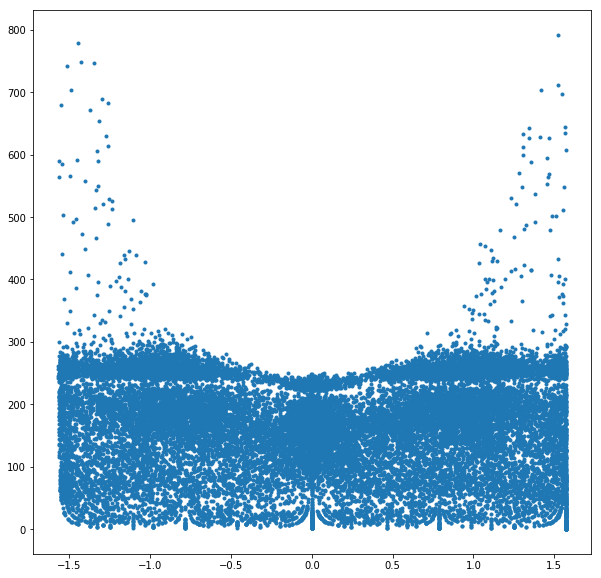

In [7]:
plt.figure(figsize=(10,10))

ax=plt.subplot(111)
ax.plot(data.angle,data.dist,'.')

<font size=3.5>
minutes_remaining and seconds_remaining

In [8]:
### add some temporal columns to the data
data['game_date_DT']=pd.to_datetime(data['game_date'])
#pd.to_datetime():將excel的unicode格式或.csv的string格式轉為Timestamp時間格式
data['dayOfWeek']=data['game_date_DT'].dt.dayofweek
#.dt.dayofweek:禮拜幾(禮拜一=0)
data['dayOfYear']=data['game_date_DT'].dt.dayofyear
#dt.dayofyear:那年的第幾天

#看時間跟shot次數的關係
data['secondsFromPeriodEnd']   = 60*data['minutes_remaining']+data['seconds_remaining']
data['secondsFromPeriodStart'] = 60*(11-data['minutes_remaining'])+(60-data['seconds_remaining'])
data['secondsFromGameStart']   = (data['period'] <= 4).astype(int)*(data['period']-1)*12*60 + (data['period'] > 4).astype(int)*((data['period']-5)*5*60 + 4*12*60) + data['secondsFromPeriodStart']

# look at first couple of rows and verify that everything is good
data.loc[:10,['period','minutes_remaining','seconds_remaining','secondsFromGameStart']]
#data.loc[]:以data的row的"label"來select出來

data=data.drop('game_date',1)
data=data.drop('game_date_DT',1)
data.head()

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,matchup,opponent,shot_id,dist,angle,dayOfWeek,dayOfYear,secondsFromPeriodEnd,secondsFromPeriodStart,secondsFromGameStart
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,...,LAL @ POR,POR,1,181.859836,0.407058,1,305,627,93,93
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,LAL @ POR,POR,2,157.000000,-0.000000,1,305,622,98,98
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,...,LAL @ POR,POR,3,168.600119,-0.928481,1,305,465,255,255
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,...,LAL @ POR,POR,4,222.865430,0.903063,1,305,412,308,308
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,...,LAL @ POR,POR,5,0.000000,1.570796,1,305,379,341,1061


<font size=3.5>
action_type, combined_shot_type, shot_type

In [9]:
#because they are categories, let's see how many types are there.
print(nona.action_type.unique())
print(nona.combined_shot_type.unique())
print(nona.shot_type.unique())

['Jump Shot' 'Driving Dunk Shot' 'Layup Shot' 'Running Jump Shot'
 'Reverse Dunk Shot' 'Slam Dunk Shot' 'Driving Layup Shot'
 'Turnaround Jump Shot' 'Reverse Layup Shot' 'Tip Shot'
 'Running Hook Shot' 'Alley Oop Dunk Shot' 'Dunk Shot'
 'Alley Oop Layup shot' 'Running Dunk Shot' 'Driving Finger Roll Shot'
 'Running Layup Shot' 'Finger Roll Shot' 'Fadeaway Jump Shot'
 'Follow Up Dunk Shot' 'Hook Shot' 'Turnaround Hook Shot' 'Jump Hook Shot'
 'Running Finger Roll Shot' 'Jump Bank Shot' 'Turnaround Finger Roll Shot'
 'Hook Bank Shot' 'Driving Hook Shot' 'Running Tip Shot'
 'Running Reverse Layup Shot' 'Driving Finger Roll Layup Shot'
 'Fadeaway Bank shot' 'Pullup Jump shot' 'Finger Roll Layup Shot'
 'Turnaround Fadeaway shot' 'Driving Reverse Layup Shot'
 'Driving Slam Dunk Shot' 'Step Back Jump shot' 'Turnaround Bank shot'
 'Reverse Slam Dunk Shot' 'Floating Jump shot' 'Putback Slam Dunk Shot'
 'Running Bank shot' 'Driving Bank shot' 'Driving Jump shot'
 'Putback Layup Shot' 'Putback Dun

<font size=3.5>

Season

In [10]:
nona['season'].unique()

array(['2000-01', '2001-02', '2002-03', '2003-04', '2004-05', '2005-06',
       '2006-07', '2007-08', '2008-09', '2009-10', '2010-11', '2011-12',
       '2012-13', '2013-14', '2014-15', '2015-16', '1996-97', '1997-98',
       '1998-99', '1999-00'], dtype=object)

Season seems to be composed of two parts: season year and season ID. Here we only need season ID. Let's modify the data.

In [11]:
data['season'] = data['season'].apply(lambda x: int(x.split('-')[1]) )
data['season'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 97,
       98, 99,  0], dtype=int64)

<font size=3.5>
team_id and team_name

In [12]:
print(nona['team_id'].unique())
print(nona['team_name'].unique())

[1610612747]
['Los Angeles Lakers']


These contain the same one value for each. Seem useless.

<font size=3.5>
opponent , matchup

In [13]:
pd.DataFrame({'matchup':nona.matchup, 'opponent':nona.opponent})

,matchup,opponent
1,LAL @ POR,POR
2,LAL @ POR,POR
3,LAL @ POR,POR
4,LAL @ POR,POR
5,LAL @ POR,POR
6,LAL @ POR,POR
8,LAL @ POR,POR
9,LAL @ POR,POR
10,LAL @ POR,POR
11,LAL vs. UTA,UTA


These are basically the same information.
Only opponent is needed.

<font size=3.5>
Shot distance

Text(0.5,1,'dist and shot_distance')

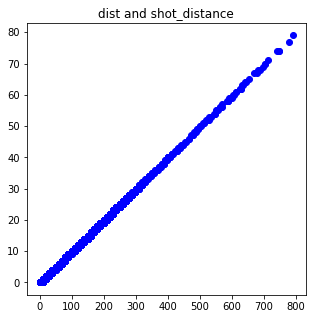

In [14]:
plt.figure(figsize=(5,5))

plt.scatter(data.dist, data.shot_distance, color='blue')
plt.title('dist and shot_distance')

shot_distance is proportional to dist and this won't be necessary.

<font size=3.5>
    shot_zone_area, shot_zone_basic, shot_zone_range

Text(0.5,1,'shot_zone_range')

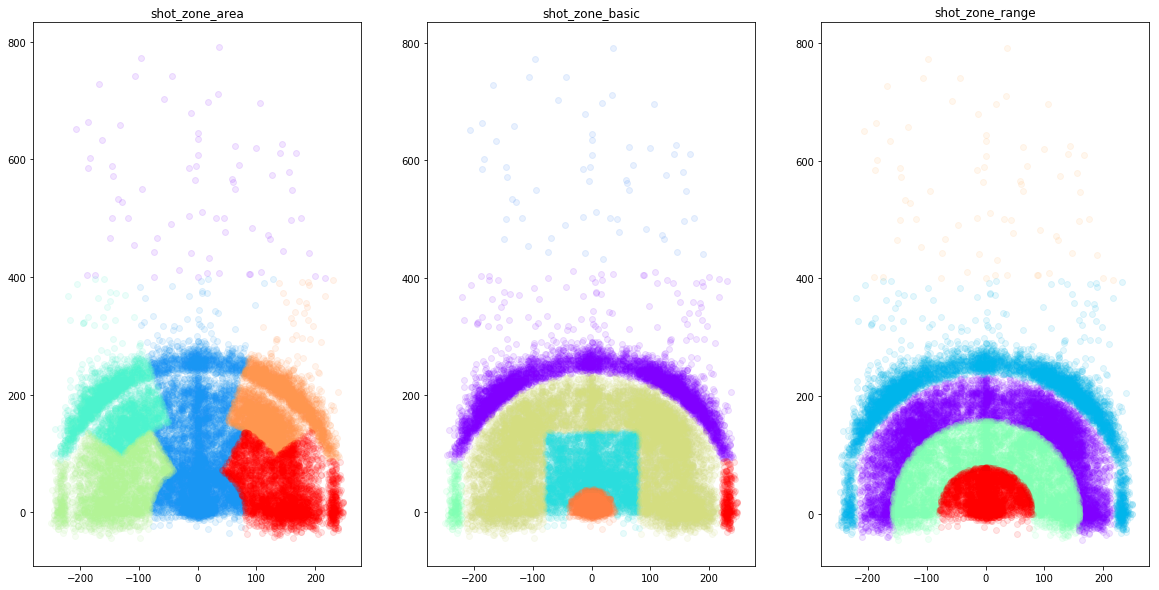

In [15]:
import matplotlib.cm as cm
plt.figure(figsize=(20,10))

def scatter_plot_by_category(feat):
    alpha = 0.1
    gs = nona.groupby(feat)
    cs = cm.rainbow(np.linspace(0, 1, len(gs)))
    for g, c in zip(gs, cs):
        plt.scatter(g[1].loc_x, g[1].loc_y, color=c, alpha=alpha)

# shot_zone_area
plt.subplot(131)
scatter_plot_by_category('shot_zone_area')
plt.title('shot_zone_area')

# shot_zone_basic
plt.subplot(132)
scatter_plot_by_category('shot_zone_basic')
plt.title('shot_zone_basic')

# shot_zone_range
plt.subplot(133)
scatter_plot_by_category('shot_zone_range')
plt.title('shot_zone_range')

As we thought, these represent regions on the court. However, these regions can be separated by dist and angle. So we don't need these.

<font size=3.5>
dropping unneeded variables
<font size=2.5>
Let's drop unnecessary variables.

In [16]:
drops = ['shot_id', 'team_id', 'team_name', 'shot_zone_area', 'shot_zone_range', 'shot_zone_basic', \
         'matchup', 'lon', 'lat', 'seconds_remaining', 'minutes_remaining', \
         'shot_distance', 'loc_x', 'loc_y', 'game_event_id', 'game_id']
for drop in drops:
    data = data.drop(drop, 1)

In [17]:
data.head()

,action_type,combined_shot_type,period,playoffs,season,shot_made_flag,shot_type,opponent,dist,angle,dayOfWeek,dayOfYear,secondsFromPeriodEnd,secondsFromPeriodStart,secondsFromGameStart
0,Jump Shot,Jump Shot,1,0,1,NaN,2PT Field Goal,POR,181.859836,0.407058,1,305,627,93,93
1,Jump Shot,Jump Shot,1,0,1,0.0,2PT Field Goal,POR,157.000000,-0.000000,1,305,622,98,98
2,Jump Shot,Jump Shot,1,0,1,1.0,2PT Field Goal,POR,168.600119,-0.928481,1,305,465,255,255
3,Jump Shot,Jump Shot,1,0,1,0.0,2PT Field Goal,POR,222.865430,0.903063,1,305,412,308,308
4,Driving Dunk Shot,Dunk,2,0,1,1.0,2PT Field Goal,POR,0.000000,1.570796,1,305,379,341,1061


<font size=3.5>
make dummy variables
    <font size=2.5>

We are going to use randomForest classifier for building our models but this doesn't accept string variables like 'action_type'. So we are going to make dummy variables for those.

In [18]:
# turn categorical variables into dummy variables
categorical_vars = ['action_type', 'combined_shot_type', 'shot_type', 'opponent', 'period', 'season']
for var in categorical_vars:
    data = pd.concat([data, pd.get_dummies(data[var], prefix=var)], 1)
    data = data.drop(var, 1)

<font size=3.5>
separating data for training and submission
<font size=2.5>
Now let's separate data.

In [19]:
df = data[pd.notnull(data['shot_made_flag'])]
submission = data[pd.isnull(data['shot_made_flag'])]
submission = submission.drop('shot_made_flag', 1)

# separate df into explanatory and response variables
train = df.drop('shot_made_flag', 1)
train_y = df['shot_made_flag']

<font size=3.5>
logloss
<font size=2>
Submissions are evaluated on the log loss. We are going to use it for evaluating our model.

In [20]:
import scipy as sp
def logloss(act, pred):
    epsilon = 1e-15
    pred = sp.maximum(epsilon, pred)
    pred = sp.minimum(1-epsilon, pred)
    ll = sum(act*sp.log(pred) + sp.subtract(1,act)*sp.log(sp.subtract(1,pred)))
    ll = ll * -1.0/len(act)
    return ll

<font size=4 color='blue'>    
Building a model
<font size=3 color='gray'>
Now it's time to build a model. We use randomForest classifier and k-fold cross validation for testing our model. We are going to...

1.pick a n from n_range for the number of estimators in randomForestClassifier.
2.divide the training data into 10 pieces.
3.pick 9 of them for building a model and use the remaining 1 for testing a model.
4.repeat the same process for the other 9 pieces.
5.calculate score for each and take an average of them. 
6.pick the next n and do the process again.
7.find the n which gave the best score among n_range.
8.repeat the same process with the tree depth parameter.
You can change the value of np.logspace for searching optimum value in broader area.

In [21]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix
import time
from sklearn.cross_validation import KFold

C:\Users\User\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [22]:
# find the best n_estimators for RandomForestClassifier
print('Finding best n_estimators for RandomForestClassifier...')
min_score = 100000
best_n = 0
scores_n = []
range_n = np.logspace(0,2,num=3).astype(int)
for n in range_n:
    print("the number of trees : {0}".format(n))
    t1 = time.time()
    
    rfc_score = 0.
    rfc = ensemble.RandomForestClassifier(n_estimators=n)
    for train_k, test_k in KFold(len(train), n_folds=10, shuffle=True):
        rfc.fit(train.iloc[train_k], train_y.iloc[train_k])
        #rfc_score += rfc.score(train.iloc[test_k], train_y.iloc[test_k])/10
        pred = rfc.predict(train.iloc[test_k])
        rfc_score += logloss(train_y.iloc[test_k], pred) / 10
    scores_n.append(rfc_score)
    if rfc_score < min_score:
        min_score = rfc_score
        best_n = n
        
    t2 = time.time()
    print('Done processing {0} trees ({1:.3f}sec)'.format(n, t2-t1))
print(best_n, min_score)


# find best max_depth for RandomForestClassifier
print('Finding best max_depth for RandomForestClassifier...')
min_score = 100000
best_m = 0
scores_m = []
range_m = np.logspace(0,2,num=3).astype(int)
for m in range_m:
    print("the max depth : {0}".format(m))
    t1 = time.time()
    
    rfc_score = 0.
    rfc = ensemble.RandomForestClassifier(max_depth=m, n_estimators=best_n)
    for train_k, test_k in KFold(len(train), n_folds=10, shuffle=True):
        rfc.fit(train.iloc[train_k], train_y.iloc[train_k])
        #rfc_score += rfc.score(train.iloc[test_k], train_y.iloc[test_k])/10
        pred = rfc.predict(train.iloc[test_k])
        rfc_score += logloss(train_y.iloc[test_k], pred) / 10
    scores_m.append(rfc_score)
    if rfc_score < min_score:
        min_score = rfc_score
        best_m = m
    
    t2 = time.time()
    print('Done processing {0} trees ({1:.3f}sec)'.format(m, t2-t1))
print(best_m, min_score)

Finding best n_estimators for RandomForestClassifier...
the number of trees : 1
Done processing 1 trees (1.732sec)
the number of trees : 10
Done processing 10 trees (9.082sec)
the number of trees : 100
Done processing 100 trees (85.418sec)
100 11.615590435836788
Finding best max_depth for RandomForestClassifier...
the max depth : 1
Done processing 1 trees (8.437sec)
the max depth : 10
Done processing 10 trees (29.846sec)
the max depth : 100
Done processing 100 trees (85.596sec)
10 11.014768094634245


Visualizing parameters for randomForest

By visualizing the parameters, we can check if the chosen parameter is really the best.

Text(0.5,0,'max depth')

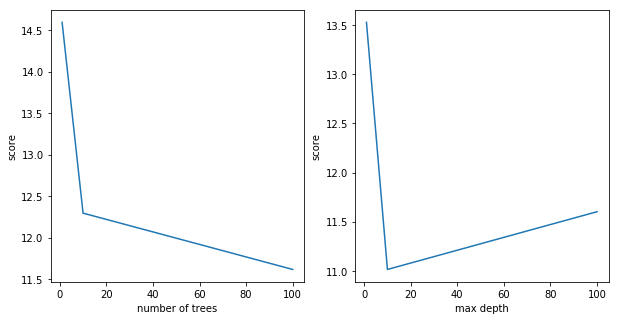

In [23]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(range_n, scores_n)
plt.ylabel('score')
plt.xlabel('number of trees')

plt.subplot(122)
plt.plot(range_m, scores_m)
plt.ylabel('score')
plt.xlabel('max depth')

<font size=4 color='blue'>
Building a final model
<font size=3 color='gray'>
Let's use the parameters we just got for the final model and prediction.

In [24]:
model = ensemble.RandomForestClassifier(n_estimators=best_n, max_depth=best_m)
model.fit(train, train_y)
pred = model.predict_proba(submission)

<font size=4 color='blue'>
Making submission data
<font size=3 color='gray'>
Predicted shot_made_flag is written to a csv file.

In [25]:
sub = pd.read_csv("sample_submission.csv")
sub['shot_made_flag'] = pred
sub.to_csv("real_submission.csv", index=False)

<font size=5,color=red>/////////////////////////////////////////////////////////////////////////////////////

Text(0.5,1,'action_type')

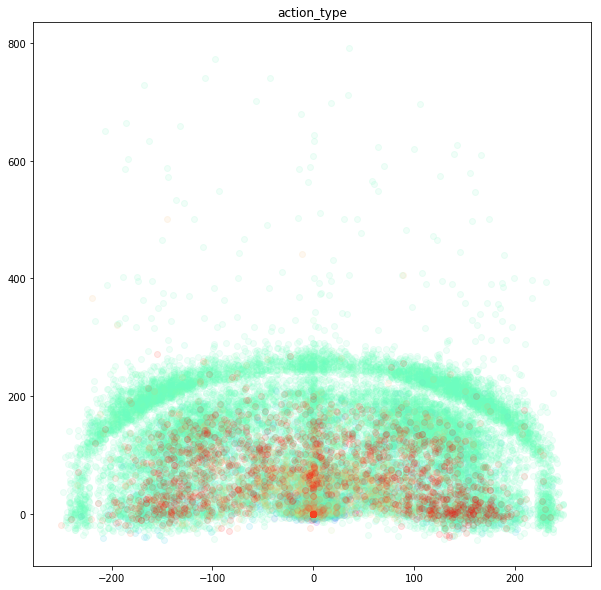

In [21]:
import matplotlib.cm as cm
plt.figure(figsize=(20,10))

def scatter_plot_by_category(feat):
    alpha = 0.1
    gs = data.groupby(feat)
    cs = cm.rainbow(np.linspace(0, 1, len(gs)))
    for g, c in zip(gs, cs):
        plt.scatter(g[1].loc_x, g[1].loc_y, color=c, alpha=alpha)


plt.figure(figsize=(10,10))
scatter_plot_by_category('action_type')
plt.title('action_type')

<font size=4 color='blue'>
    Plot Shot Attempts as a function of time during the game
<font size=3 color='gray'>
here we apply 3 different binnings of time and show the attempts as function from game start

Text(0.5,0,'time [seconds from start of game]')

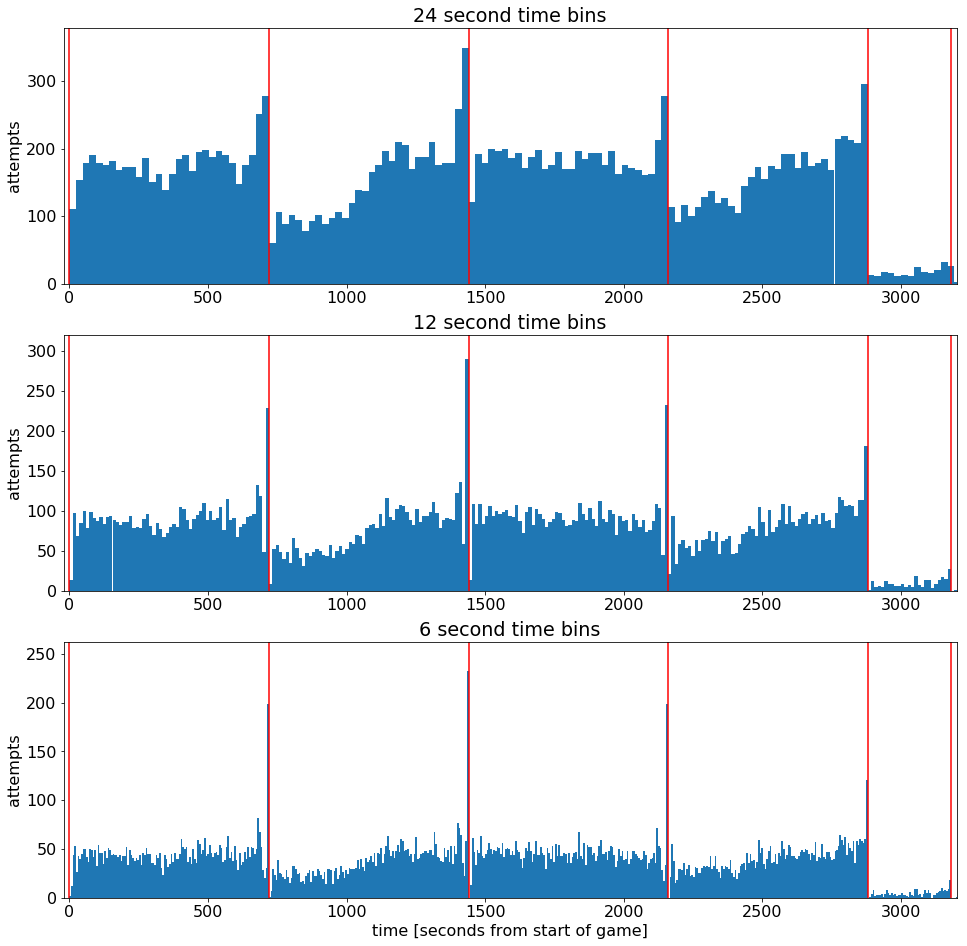

In [3]:
# plot the shot attempts as a function of time (from start of game) with several different binnings
plt.rcParams['figure.figsize'] = (16, 16)
plt.rcParams['font.size'] = 16
#設定plt的參數

binsSizes = [24,12,6]
#bin:直條圖的每個值條的區間大小

plt.figure();#建立畫布
for k, binSizeInSeconds in enumerate(binsSizes): 
    #enumerate:將iterable的東西變成有index的 輸出index跟item
    timeBins = np.arange(0,60*(4*12+3*5),binSizeInSeconds)+0.01
    attemptsAsFunctionOfTime, b = np.histogram(data['secondsFromGameStart'], bins=timeBins)     
    #bins:如果參數是int就是總共int個區間(取等寬) 如果參數是sequence(例如這裡)就是根據給的值取區間
    maxHeight = max(attemptsAsFunctionOfTime) + 30
    barWidth = 0.999*(timeBins[1]-timeBins[0])
    plt.subplot(len(binsSizes),1,k+1); 
    plt.bar(timeBins[:-1],attemptsAsFunctionOfTime, align='edge', width=barWidth); plt.title(str(binSizeInSeconds) + ' second time bins')
    plt.vlines(x=[0,12*60,2*12*60,3*12*60,4*12*60,4*12*60+5*60,4*12*60+2*5*60,4*12*60+3*5*60], ymin=0,ymax=maxHeight, colors='r')
    plt.xlim((-20,3200)); plt.ylim((0,maxHeight)); plt.ylabel('attempts')
plt.xlabel('time [seconds from start of game]')

In [ ]:
data.head()

<font size=3 color='gray'>
It looks like Kobe is entrusted to take the last shot of every period
it also looks like he's usually on the bench at the start of 2nd and 4th periods

<font size=4 color='blue'>
Plot Shot Accuracy as function of time during the game

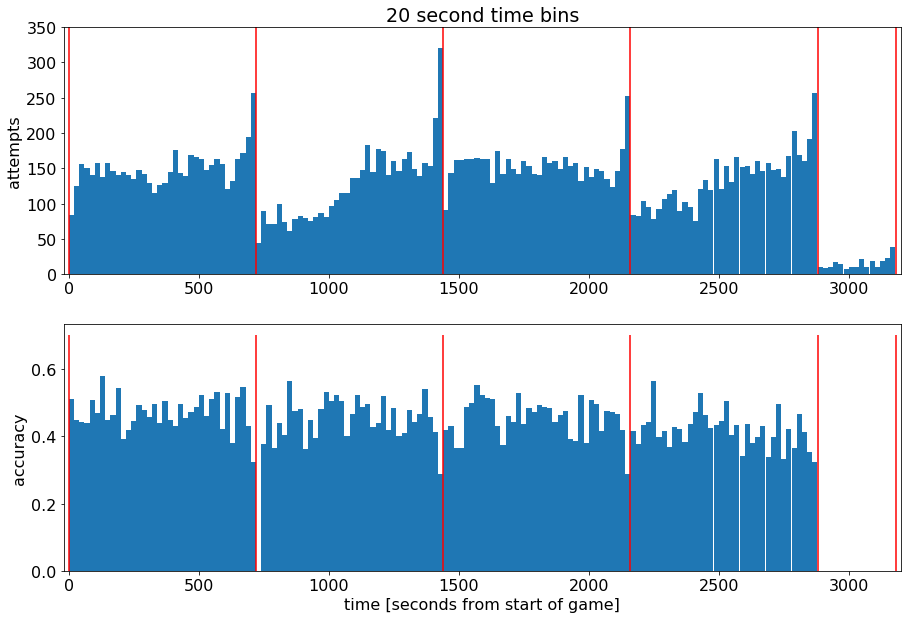

In [4]:
#%% plot the accuracy as a function of time
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 16

binSizeInSeconds = 20
timeBins = np.arange(0,60*(4*12+3*5),binSizeInSeconds)+0.01
attemptsAsFunctionOfTime,     b = np.histogram(data['secondsFromGameStart'], bins=timeBins)     
madeAttemptsAsFunctionOfTime, b = np.histogram(data.loc[data['shot_made_flag']==1,'secondsFromGameStart'], bins=timeBins)     
#取histogram就是根據給的資料取把其值按照取的區間計算符合其區間的值有多少個
attemptsAsFunctionOfTime[attemptsAsFunctionOfTime < 1] = 1
#因為sample數必為整數 所以這裡代表把0個sample改成1個sample=>接下來要當分母
accuracyAsFunctionOfTime = madeAttemptsAsFunctionOfTime.astype(float)/attemptsAsFunctionOfTime
accuracyAsFunctionOfTime[attemptsAsFunctionOfTime <= 50] = 0 # zero accuracy in bins that don't have enough samples
#以免因為sample數小造成大誤差，但接下來在圖中我覺得要有legend說明像是最後一節的accuracy等於0是我們手動去掉的 不是真的為0

maxHeight = max(attemptsAsFunctionOfTime) + 30
barWidth = 0.99*(timeBins[1]-timeBins[0])

plt.figure();
plt.subplot(2,1,1); plt.bar(timeBins[:-1],attemptsAsFunctionOfTime, align='edge', width=barWidth); 
plt.xlim((-20,3200)); plt.ylim((0,maxHeight)); plt.ylabel('attempts'); plt.title(str(binSizeInSeconds) + ' second time bins')
plt.vlines(x=[0,12*60,2*12*60,3*12*60,4*12*60,4*12*60+5*60,4*12*60+2*5*60,4*12*60+3*5*60], ymin=0,ymax=maxHeight, colors='r')
plt.subplot(2,1,2); plt.bar(timeBins[:-1],accuracyAsFunctionOfTime, align='edge', width=barWidth); 
plt.xlim((-20,3200)); plt.ylabel('accuracy'); plt.xlabel('time [seconds from start of game]')
plt.vlines(x=[0,12*60,2*12*60,3*12*60,4*12*60,4*12*60+5*60,4*12*60+2*5*60,4*12*60+3*5*60], ymin=0.0,ymax=0.7, colors='r')

 <font size=3 color='gray'>
    Note that the accuracy of these "last second shots" is consisently lower than usuall
This is probably due to the fact that a large amonut of these shots are from very far away
    因為sample數小造成大誤差，但在圖中我覺得要有legend說明像是最後一節的accuracy等於0是我們手動去掉的 不是真的為0

<font size=4 color='blue'>
    Now let's continue our initial exploration and examine the spatial location aspect of kobe's shots than usuall
<font size=3 color='gray'>
we'll do this by building a gaussian mixture model that tries to summerize Kobe's shot locations compactly
    ??:要根據shot的地點做分群 那不是用kmeans可以分的劃界更徹底?(高斯混和模型是依據機率分布來分群)

In [6]:
#%% cluster the shot attempts of kobe using GMM on their location
numGaussians = 13
gaussianMixtureModel = mixture.GaussianMixture(n_components=numGaussians, covariance_type='full', 
                                               init_params='kmeans', n_init=50, 
                                               verbose=0, random_state=5)
gaussianMixtureModel.fit(Traindata.loc[:,['loc_x','loc_y']])

# add the GMM cluster as a field in the dataset
Traindata['shotLocationCluster'] = gaussianMixtureModel.predict(Traindata.loc[:,['loc_x','loc_y']])

In [8]:
Traindata['shotLocationCluster'].shape


(20553,)

<font size=4 color='blue'>
   Define some helpful functions
<font size=3 color='gray'>
the function draw_court() is shamelessly stolen from MichaelKrueger's excelent script)

In [8]:
#%% define draw functions (stealing shamelessly the draw_court() function from MichaelKrueger's excelent script)

def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()#get the curent axes 

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw,
                               color=color)
    corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]

    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

def Draw2DGaussians(gaussianMixtureModel, ellipseColors, ellipseTextMessages):
    
    fig, h = plt.subplots();
    for i, (mean, covarianceMatrix) in enumerate(zip(gaussianMixtureModel.means_, gaussianMixtureModel.covariances_)):
        # get the eigen vectors and eigen values of the covariance matrix
        v, w = np.linalg.eigh(covarianceMatrix)
        v = 2.5*np.sqrt(v) # go to units of standard deviation instead of variance
        
        # calculate the ellipse angle and two axis length and draw it
        u = w[0] / np.linalg.norm(w[0])    
        angle = np.arctan(u[1] / u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        currEllipse = mpl.patches.Ellipse(mean, v[0], v[1], 180 + angle, color=ellipseColors[i])
        currEllipse.set_alpha(0.5)
        h.add_artist(currEllipse)
        h.text(mean[0]+7, mean[1]-1, ellipseTextMessages[i], fontsize=13, color='blue')

<font size=4 color='blue'>
   Draw the 2D Gaussians of Shot Attempts
<font size=3 color='gray'>
Each elipse is the countour that represents 2.5 standard deviations away from the center of the gaussian Each number in blue represents the precent of shots taken from this gaussian out of all shots
??:試試用kmeans分群後 算各群佔的比例 是不是跟底下的圖示差不多

Text(0.5,1,'shot attempts')

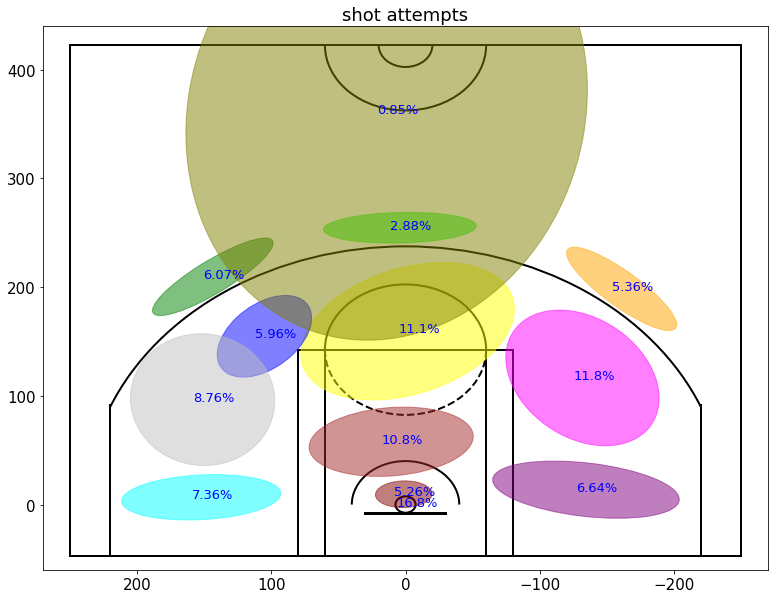

In [9]:
#%% show gaussian mixture elipses of shot attempts
plt.rcParams['figure.figsize'] = (13, 10)
plt.rcParams['font.size'] = 15

ellipseTextMessages = [str(100*gaussianMixtureModel.weights_[x])[:4]+'%' for x in range(numGaussians)]
ellipseColors = ['red','green','purple','cyan','magenta','yellow','blue','orange','silver','maroon','lime','olive','brown','darkblue']
Draw2DGaussians(gaussianMixtureModel, ellipseColors, ellipseTextMessages)
draw_court(outer_lines=True); plt.ylim(-60,440); plt.xlim(270,-270); plt.title('shot attempts')

Training data:
跟整個data的結果趨勢有點差異，尤其在藍前的左右邊attempt大小關係是相反的，training data是表示較喜歡從左邊shot


all data: 
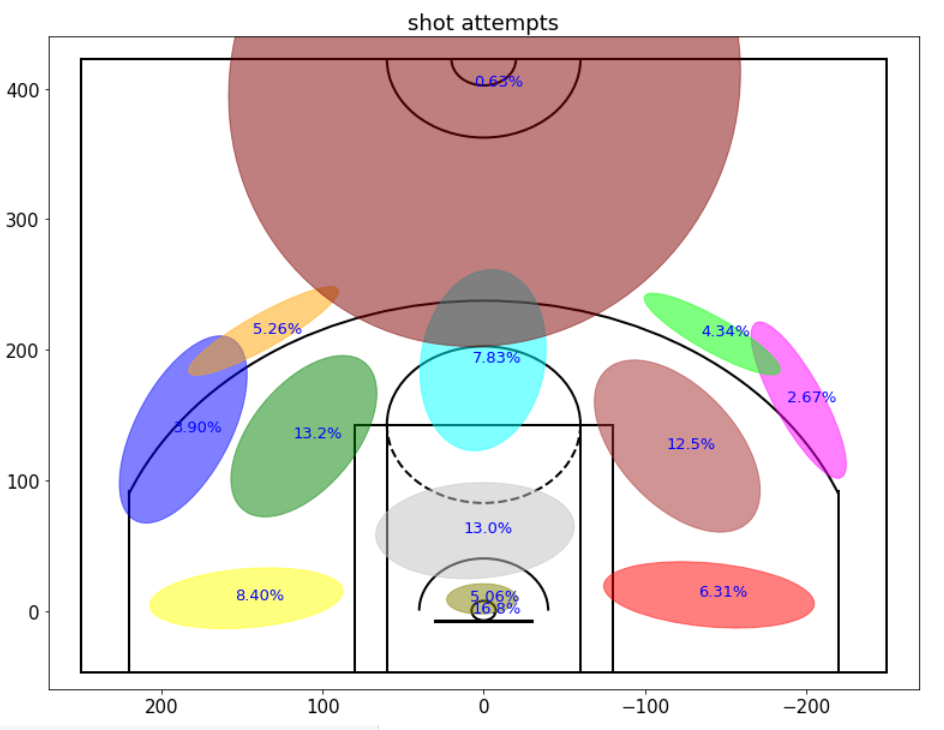We can see that Kobe is making more attempts from the left side of the court (or right side from his point of view). this is probably because he's right handed.

Also, we can see that a huge number of attempts (16.8%) is from directly under the basket, and 5.06% additinal attemps are from very close to the basket

<font size=4 color='blue'>
Show the Scatter Plot of all Kobe's shot attempts colored by the cluster assignment according to the GMM
<font size=3 color='gray'>
Just to make sure the gaussian model actually captures something

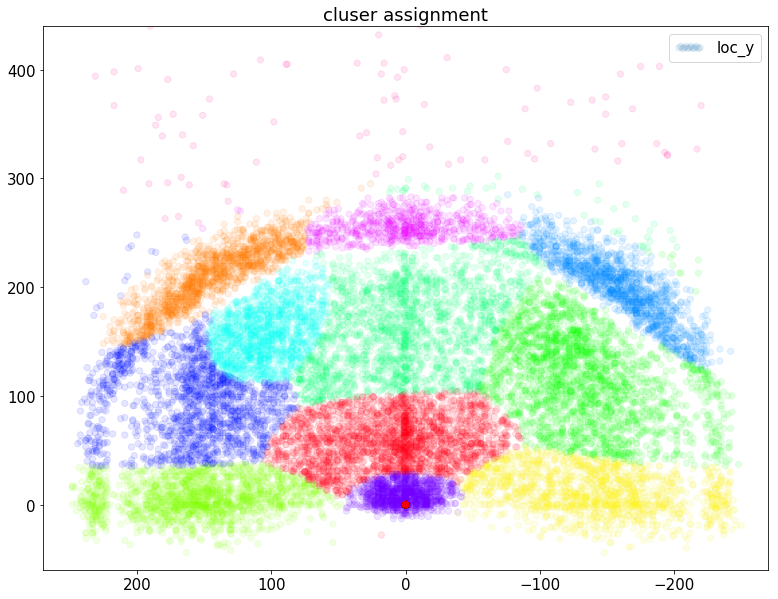

In [13]:
#%% just to make sure the gaussian model actually captures something, show the scatter and cluster assignment
plt.rcParams['figure.figsize'] = (13, 10)
plt.rcParams['font.size'] = 15

plt.figure(); #draw_court(outer_lines=True); 
plt.ylim(-60,440); plt.xlim(270,-270); plt.title('cluser assignment')
plt.scatter(x=Traindata['loc_x'],y=Traindata['loc_y'],c=Traindata['shotLocationCluster'],s=40,cmap='hsv',alpha=0.1)
plt.legend(scatterpoints=13)

It doesn't seem perfect, but definatly captures some interesting things about the data for example, we can see that the large and very far away cluster is capturing all of the very distant shots

<font size=4 color='blue'>
Plot the Shot Accuracy of each Gaussian Cluster
<font size=3 color='gray'>
Each blue number here will represent the accuracy of the shots taken from this cluster so we can get a feel for what are easy and what are difficult shots

Text(0.5,1,'shot accuracy')

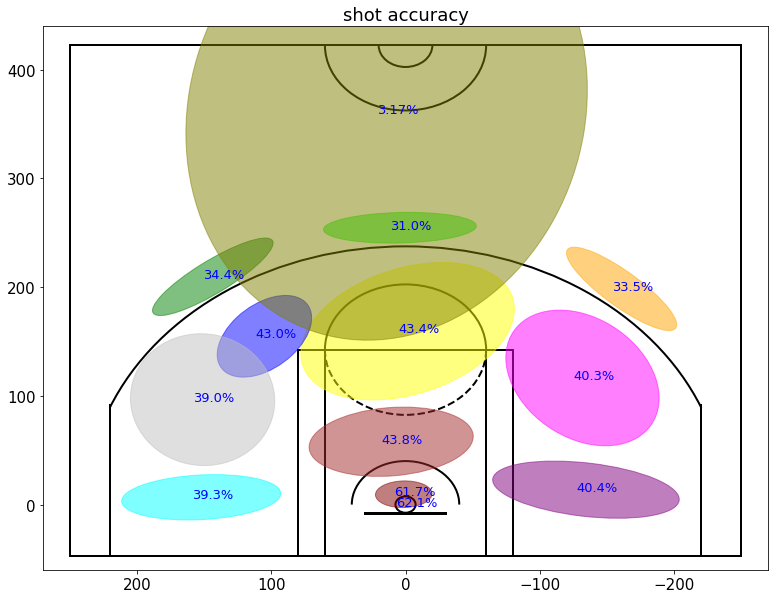

In [11]:
#%% for each cluster, calculate its individual accuracy and plot it
plt.rcParams['figure.figsize'] = (13, 10)
plt.rcParams['font.size'] = 15

variableCategories = data['shotLocationCluster'].value_counts().index.tolist()
#.value_counts():計算各cluster編號有多少sample並由大到小排列(index:cluster編號,value:多少sample) 
#.index:取得其index #.tolist():轉成list儲存起來

clusterAccuracy = {}
for category in variableCategories:
    shotsAttempted = np.array(data['shotLocationCluster'] == category).sum()
    shotsMade = np.array(data.loc[data['shotLocationCluster'] == category,'shot_made_flag'] == 1).sum()
    clusterAccuracy[category] = float(shotsMade)/shotsAttempted

ellipseTextMessages = [str(100*clusterAccuracy[x])[:4]+'%' for x in range(numGaussians)]
Draw2DGaussians(gaussianMixtureModel, ellipseColors, ellipseTextMessages)
draw_court(outer_lines=True); plt.ylim(-60,440); plt.xlim(270,-270); plt.title('shot accuracy')

We can clearly see the dependence between distance and accuracy.

training data:
綜合attempts的那張圖，左邊進攻次數多且投進的機率也高。
而從all data來看則是右邊進攻多且投進機率較高(相反)

all data:
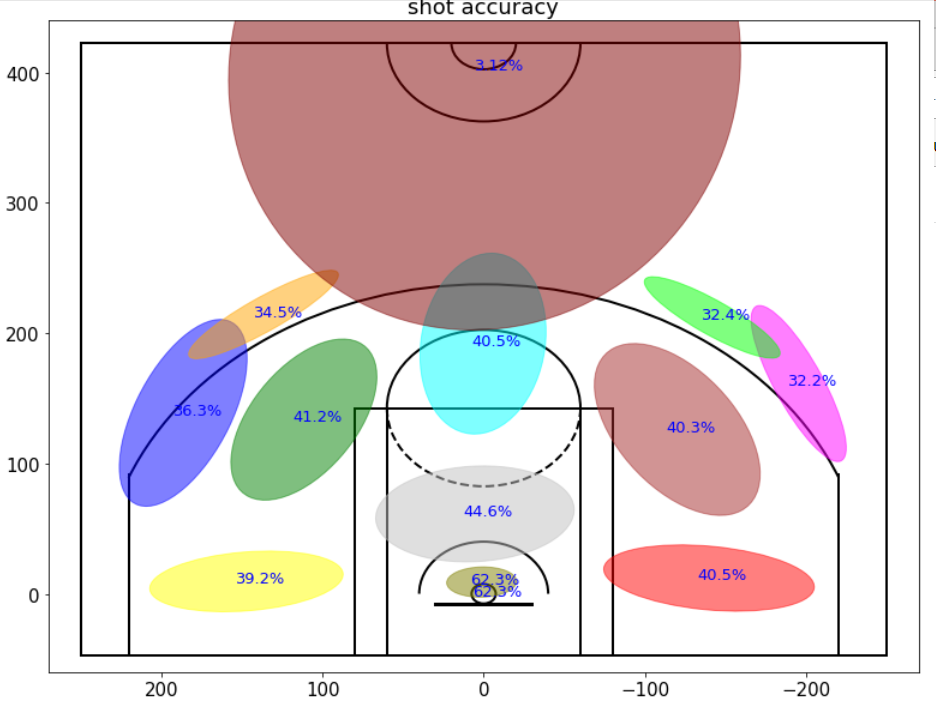
Another interesting fact is that Kobe not only makes more attempts from the right side (from his point of view), but also he's better at making those attempts

<font size=4 color='blue'>
Now let's Plot a 2D Spatio-Temporal plot of Kobe's career
<font size=3 color='gray'>
-on x-axis there will be time since start of game
-on y-axis there will be the cluster index Kobe made the shot (sorted by the cluster accuracy)
-the intensity will be the number of attempts by Kobe from that particular cluster at that particular time
-red verticle lines are the end of each period

Text(0,0.5,'cluster (sorted by accuracy)')

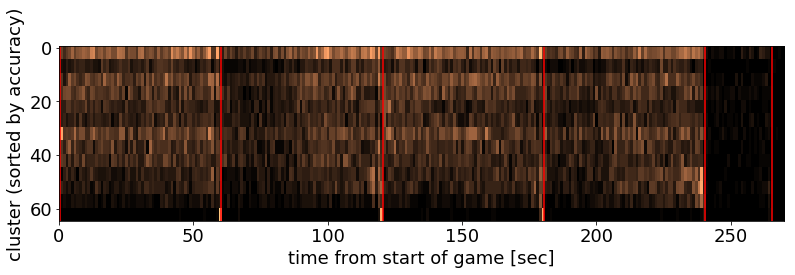

In [12]:
#%% plot a 2-d spatio-temporal histogram of kobe's games during his entire carrer
plt.rcParams['figure.figsize'] = (18, 10)
plt.rcParams['font.size'] = 18

# sort the clusters according to their accuracy
sortedClustersByAccuracyTuple = sorted(clusterAccuracy.items(), key=operator.itemgetter(1),reverse=True)
#sorted()的key:控制是以甚麼來當排序的基準。operator.itemgetter(0):以輸入data的index=0來當排序的標準
sortedClustersByAccuracy = [x[0] for x in sortedClustersByAccuracyTuple]

binSizeInSeconds = 12
timeInUnitsOfBins = ((data['secondsFromGameStart']+0.0001)/binSizeInSeconds).astype(int)
#把時間scale縮小，才不會把整個軸拉太長
locationInUintsOfClusters = np.array([sortedClustersByAccuracy.index(data.loc[x,'shotLocationCluster']) for x in range(data.shape[0])])
#得到一個array儲存每一筆資料屬於哪個accuracy排名中的第幾名

# build a spatio-temporal histogram of Kobe's games
shotAttempts = np.zeros((gaussianMixtureModel.n_components,1+max(timeInUnitsOfBins)))
for shot in range(data.shape[0]):
    shotAttempts[locationInUintsOfClusters[shot],timeInUnitsOfBins[shot]] += 1

    
# make the y-axis have larger area so it will be more visible 
shotAttempts = np.kron(shotAttempts,np.ones((5,1)))
#Kronecker積:主要用途在於便利表達矩陣方程式 A張量積 B: A是形式 B是值     
# the locations of the period ends
vlinesList = 0.5001+np.array([0,12*60,2*12*60,3*12*60,4*12*60,4*12*60+5*60]).astype(int)/binSizeInSeconds

plt.figure(figsize=(13,8))
plt.imshow(shotAttempts, cmap='copper',interpolation="nearest"); plt.xlim(0,float(4*12*60+6*60)/binSizeInSeconds);
plt.vlines(x=vlinesList, ymin=-0.5,ymax=shotAttempts.shape[0]-0.5, colors='r');
plt.xlabel('time from start of game [sec]'); plt.ylabel('cluster (sorted by accuracy)')

The clusters are sorted in descending order of accuracy. under the basek high accuracy shots are at the top, and low accuracy shots from half court are at the bottom
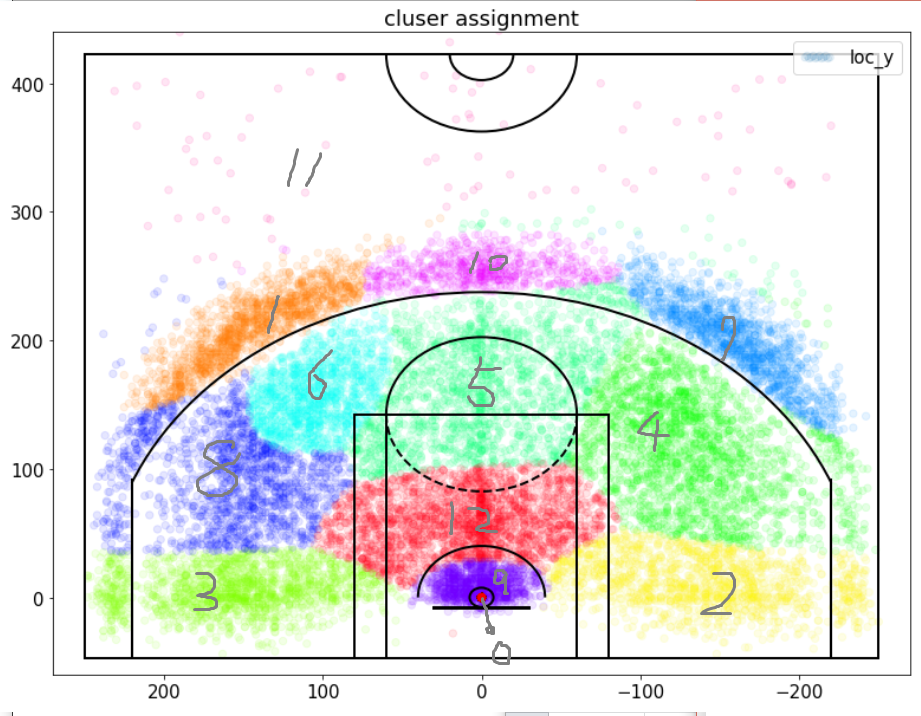
We can now see that the "last second shots" in the 1st, 2nd and 3rd periods were indeed "hopeless shots" from very far away(看接近節尾時，下半部的cluster的亮度比之前大，代表shot數變多)
It's interesting to note, however, that in the 4th period, the last second shot don't belong to the "hopeless" cluster, but rather to the regular 3-pointer clusters (which are still much more difficult, but not hopeless)